In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:

def simulate_discrete_landmark_dynamics(
    gain,
    v=3,
    k_0=2 * np.pi / 100,
    locomotor_strength=0.5,
    dt=1,
    strength_LM=0.1,
    time=1000,
    track_length=400,
    landmark_spacing=80,
    landmark_radius=20
):
    
    def calc_k_A(k_0, gain, locomotor_strength):
        deltaG = gain - 1
        return k_0 * (1 + deltaG * (1 - locomotor_strength))

    def calc_k_L(k_0, gain):
        return k_0 * gain

    def update_position(dt, x, gain, v):
        return (x + dt * gain * v) % 400

    def update_phaseLM(dt, phi_L, k_L, v):
        return (phi_L + dt * k_L * v) % (2 * np.pi)

    def calc_decoherence(k_0, v, locomotor_strength, gain, strength_LM):
        return -k_0 * v * locomotor_strength * (gain - 1) / strength_LM
    

    def wrap_phase_diff(delta_phi_list):
        wrapped = []
        for dphi in delta_phi_list:
            if abs(dphi) > np.pi:
                wrapped.append((np.pi - dphi) / abs(np.pi - dphi) * ((np.pi - dphi) % np.pi))
            else:
                wrapped.append(dphi)
        return wrapped
    
    k_A = calc_k_A(k_0, gain, locomotor_strength)
    k_L = calc_k_L(k_0, gain)
    decoherence = calc_decoherence(k_0, v, locomotor_strength, gain, strength_LM)

    phi_A = 0
    phi_L = 0
    x = 0
    phi_A_t = []
    phi_L_t = []
    x_t = []
    input_LM_t = []

    landmark_positions = np.arange(landmark_spacing / 2, track_length, landmark_spacing)

    def landmark_active(x):
        return any(abs(x - lm_x) <= landmark_radius for lm_x in landmark_positions)

    for t in range(time):
        x = update_position(dt, x, gain, v)
        phi_L = update_phaseLM(dt, phi_L, k_L, v)

        # visual input gated by landmark activity
        H = 1 if landmark_active(x) else 0
        input_vel = k_A * v
        input_LM = strength_LM * H * np.sin(phi_L - phi_A)
        dphi_A = dt * (input_vel + input_LM)
        phi_A = (phi_A + dphi_A) % (2 * np.pi)

        phi_L_t.append(phi_L)
        phi_A_t.append(phi_A)
        x_t.append(x)
        input_LM_t.append(input_LM)

    deltaPhi = [a - l for a, l in zip(phi_A_t, phi_L_t)]
    deltaPhi = wrap_phase_diff(deltaPhi)
    deltaPhi_diff = np.diff(deltaPhi)

    return {
        'phi_A_t': phi_A_t,
        'phi_L_t': phi_L_t,
        'x_t': x_t,
        'deltaPhi': deltaPhi,
        'deltaPhi_diff': deltaPhi_diff,
        'gain': gain,
        'decoherence': decoherence
    }

results_discrete = {
    g: simulate_discrete_landmark_dynamics(gain=g)
    for g in [1.0, 1.5, -1.7]
}



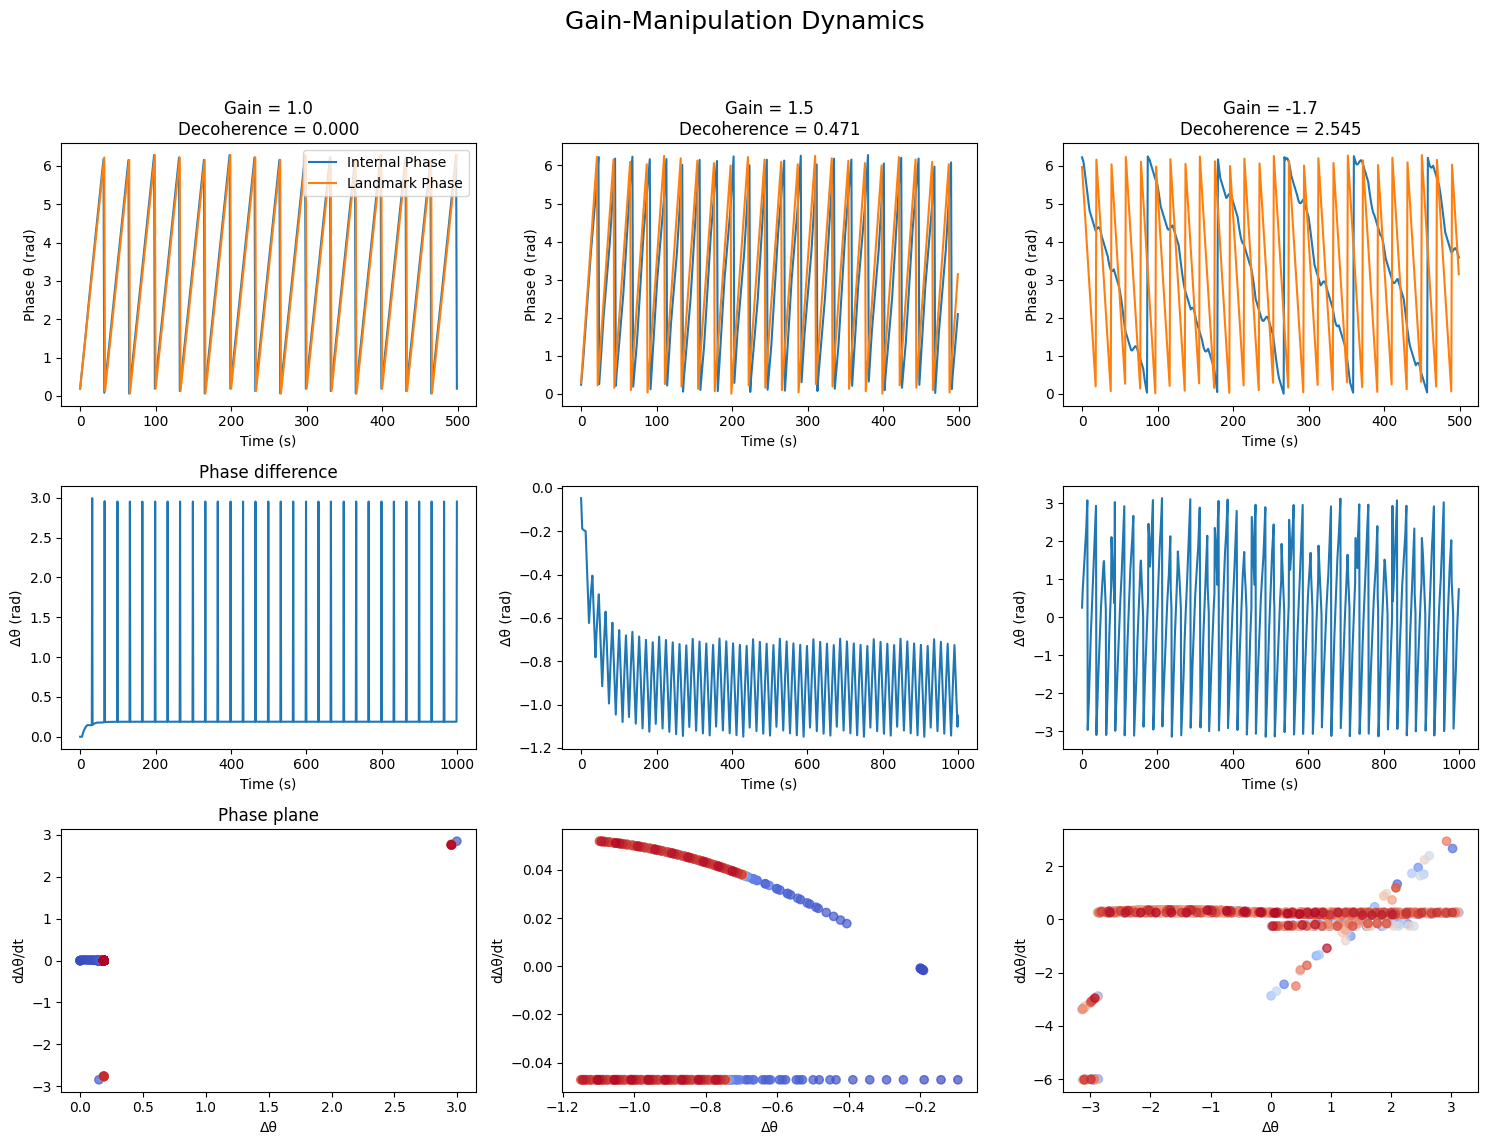

In [5]:
def plot_phase_dynamics(gains, time=1000, dt=1):
    results = [simulate_discrete_landmark_dynamics(g, time=time, dt=dt) for g in gains]
    n = len(gains)
    fig, axs = plt.subplots(3, n, figsize=(5 * n, 12), sharex=False)

    for col, res in enumerate(results):
        phi_A_t = np.array(res['phi_A_t'])
        phi_L_t = np.array(res['phi_L_t'])
        deltaPhi = np.array(res['deltaPhi'])
        deltaPhi_diff = np.array(res['deltaPhi_diff'])
        T = len(phi_A_t)
        gain = res['gain']
        decoh = abs(res['decoherence'])

        # time vectors
        t0 = np.arange(500) * dt
        t_all = np.arange(T) * dt
        t_vals = np.arange(1, T) * dt

        # Row 0: phase trajectories
        ax = axs[0, col]
        ax.plot(t0, phi_A_t[:500], label="Internal Phase")
        ax.plot(t0, phi_L_t[:500], label="Landmark Phase")
        ax.set_ylabel("Phase θ (rad)")
        ax.set_xlabel("Time (s)")
        if col == 0:
            ax.legend(loc="upper right")
        ax.set_title(f"Gain = {gain}\nDecoherence = {decoh:.3f}")

        # Row 1: phase difference
        ax = axs[1, col]
        ax.plot(t_all, deltaPhi)
        ax.set_ylabel("Δθ (rad)")
        ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_title("Phase difference")

        # Row 2: phase-plane with time-color
        ax = axs[2, col]
        scatter = ax.scatter(
            deltaPhi[1:], deltaPhi_diff,
            c=t_vals, cmap='coolwarm', alpha=0.7
        )
        ax.set_xlabel("Δθ")
        ax.set_ylabel("dΔθ/dt")
        if col == 0:
            ax.set_title("Phase plane")


    fig.suptitle("Gain-Manipulation Dynamics", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Usage
gains = [1.0, 1.5, -1.7]
plot_phase_dynamics(gains)


Drift Analysis


In [7]:
def compute_drift_between_landmarks(result, landmark_positions, landmark_radius):
    x_t = result['x_t']
    phi_A_t = np.unwrap(result['phi_A_t'])  # unwrapped for drift analysis

    drift_vals = []
    current_interval = []
    last_inside = True

    for x, phi in zip(x_t, phi_A_t):
        # check if near any landmark
        is_inside = any(abs(x - lm) <= landmark_radius for lm in landmark_positions)

        if not is_inside:
            current_interval.append(phi)
        elif not last_inside and current_interval:
            # transition back into landmark range: compute drift
            drift = current_interval[-1] - current_interval[0]
            drift_vals.append(drift)
            current_interval = []

        last_inside = is_inside

    return drift_vals


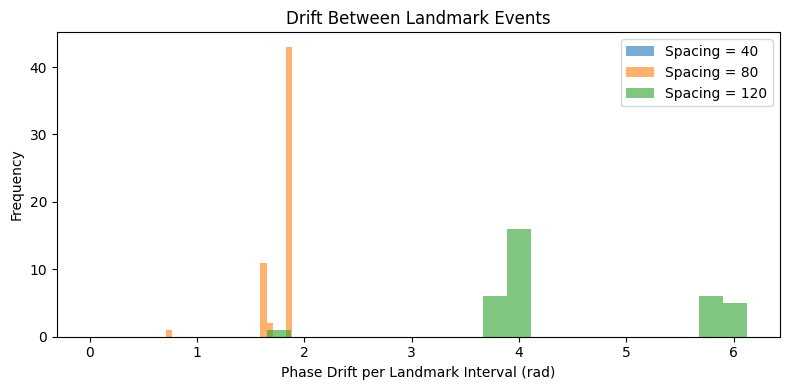

In [8]:
landmark_spacings = [40, 80, 120]
drift_distributions = {}

for spacing in landmark_spacings:
    result = simulate_discrete_landmark_dynamics(gain=1.5, landmark_spacing=spacing)
    landmarks = np.arange(spacing / 2, 400, spacing)
    drifts = compute_drift_between_landmarks(result, landmarks, 20)
    drift_distributions[spacing] = drifts

plt.figure(figsize=(8, 4))
for spacing, drifts in drift_distributions.items():
    plt.hist(drifts, bins=20, alpha=0.6, label=f'Spacing = {spacing}')
plt.xlabel('Phase Drift per Landmark Interval (rad)')
plt.ylabel('Frequency')
plt.title('Drift Between Landmark Events')
plt.legend()
plt.tight_layout()
plt.show()


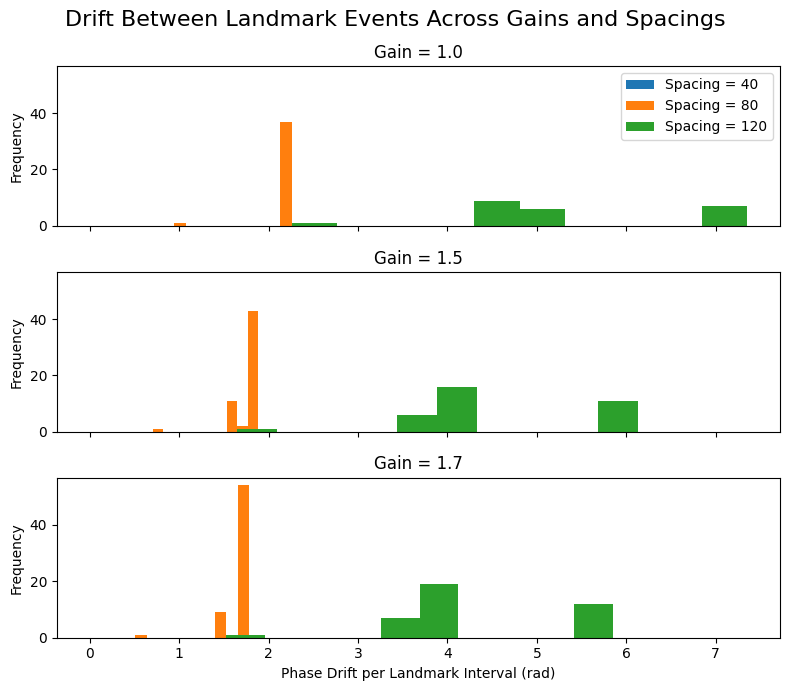

In [41]:
landmark_spacings = [40, 80, 120]
gains = [1.0, 1.5, 1.7]
landmark_radius = 20

drift_distributions = {g: {} for g in gains}

for g in gains:
    for spacing in landmark_spacings:
        result = simulate_discrete_landmark_dynamics(
            gain=g, landmark_spacing=spacing, landmark_radius=landmark_radius
        )
        landmarks = np.arange(spacing / 2, 400, spacing)
        drifts = compute_drift_between_landmarks(result, landmarks, landmark_radius)
        drift_distributions[g][spacing] = drifts

fig, axs = plt.subplots(3, 1, figsize=(8, 7), sharex=True, sharey=True)

for i, g in enumerate(gains):
    ax = axs[i]
    for spacing in landmark_spacings:
        drifts = drift_distributions[g][spacing]
        ax.hist(drifts, bins=10, alpha=1, label=f'Spacing = {spacing}')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Gain = {g}')
    if i == len(gains) - 1:
        ax.set_xlabel('Phase Drift per Landmark Interval (rad)')
    if i == 0:
        ax.legend()

fig.suptitle('Drift Between Landmark Events Across Gains and Spacings', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()


Parameter Sweep


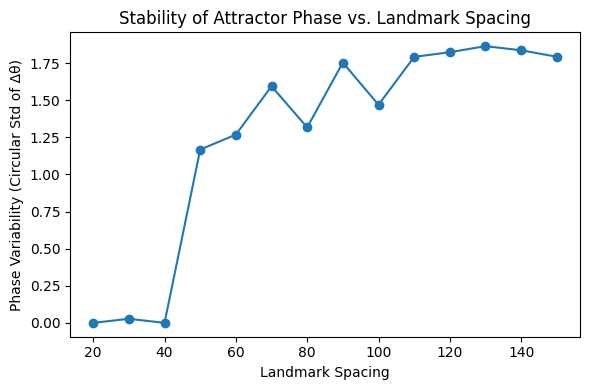

In [31]:
from scipy.stats import circstd

def sweep_landmark_spacing(spacing_vals, gain=2, landmark_radius=20):
    stability_scores = []
    for spacing in spacing_vals:
        result = simulate_discrete_landmark_dynamics(
            gain=gain,
            landmark_spacing=spacing,
            landmark_radius=landmark_radius
        )
        delta_phi = np.array(result['deltaPhi'][-200:])
        score = circstd(delta_phi, high=np.pi, low=-np.pi)
        stability_scores.append(score)
    return spacing_vals, stability_scores

spacing_vals = np.arange(20, 160, 10)
x_vals, y_vals = sweep_landmark_spacing(spacing_vals)

plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, marker='o')
plt.xlabel("Landmark Spacing")
plt.ylabel("Phase Variability (Circular Std of Δθ)")
plt.title("Stability of Attractor Phase vs. Landmark Spacing")
plt.tight_layout()
plt.show()


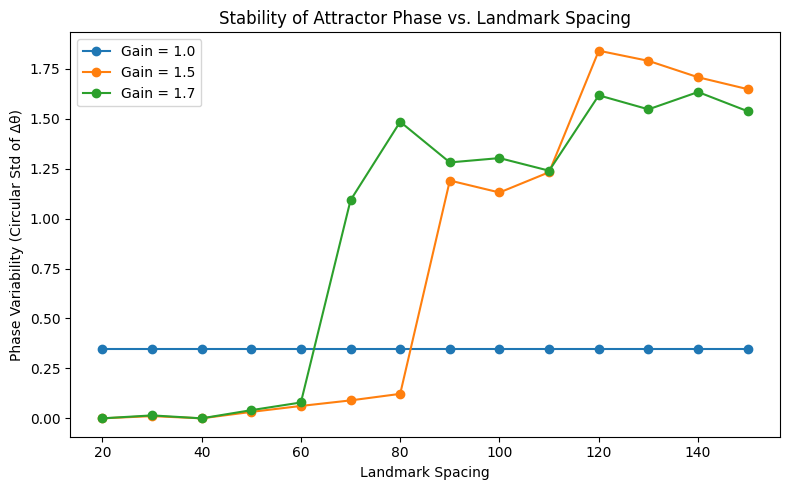

In [39]:

def compute_stability(result, tail_window=200):
    delta_phi = np.array(result['deltaPhi'][-tail_window:])
    return circstd(delta_phi, high=np.pi, low=-np.pi)

def sweep_landmark_spacing_multi_gain(
    spacing_vals, gains=[1.0, 1.5, 1.7], landmark_radius=20, time=1000
):
    stability_results = {g: [] for g in gains}

    for spacing in spacing_vals:
        for g in gains:
            result = simulate_discrete_landmark_dynamics(
                gain=g,
                landmark_spacing=spacing,
                landmark_radius=landmark_radius,
                time=time
            )
            stability = compute_stability(result)
            stability_results[g].append(stability)

    return spacing_vals, stability_results

spacing_vals = np.arange(20, 160, 10)
gains = [1.0, 1.5, 1.7]
x_vals, stability_results = sweep_landmark_spacing_multi_gain(spacing_vals, gains=gains)

plt.figure(figsize=(8, 5))
for g in gains:
    plt.plot(x_vals, stability_results[g], marker='o', label=f'Gain = {g}')
plt.xlabel("Landmark Spacing")
plt.ylabel("Phase Variability (Circular Std of Δθ)")
plt.title("Stability of Attractor Phase vs. Landmark Spacing")
plt.legend()
plt.tight_layout()
plt.show()


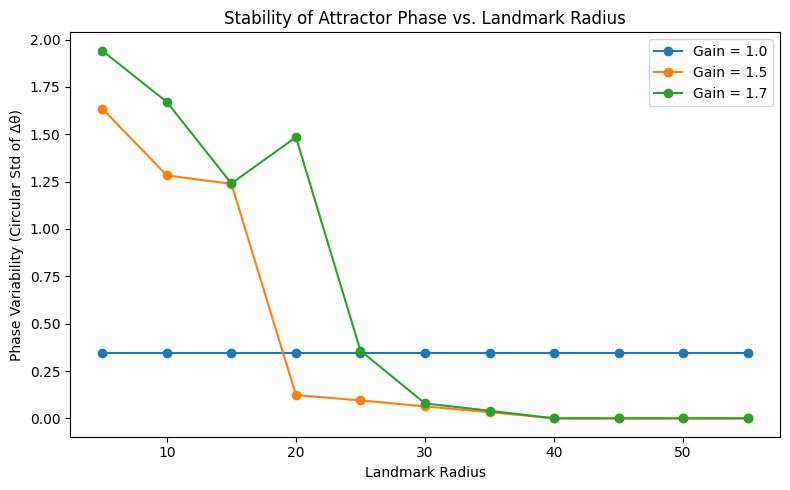

In [42]:
def sweep_landmark_radius_multi_gain(
    radius_vals, gains=[1.0, 1.5, 1.7], landmark_spacing=80, time=1000
):
    stability_results = {g: [] for g in gains}

    for radius in radius_vals:
        for g in gains:
            result = simulate_discrete_landmark_dynamics(
                gain=g,
                landmark_spacing=landmark_spacing,
                landmark_radius=radius,
                time=time
            )
            stability = compute_stability(result)
            stability_results[g].append(stability)

    return radius_vals, stability_results

radius_vals = np.arange(5, 60, 5)
gains = [1.0, 1.5, 1.7]
x_vals, stability_results = sweep_landmark_radius_multi_gain(radius_vals, gains=gains)

plt.figure(figsize=(8, 5))
for g in gains:
    plt.plot(x_vals, stability_results[g], marker='o', label=f'Gain = {g}')
plt.xlabel("Landmark Radius")
plt.ylabel("Phase Variability (Circular Std of Δθ)")
plt.title("Stability of Attractor Phase vs. Landmark Radius")
plt.legend()
plt.tight_layout()
plt.show()
